# Libraries

In [125]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from textblob import TextBlob

from os.path import exists
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from 

from sklearn.model_selection import KFold, cross_val_predict

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

import optuna
from optuna.samplers import TPESampler


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

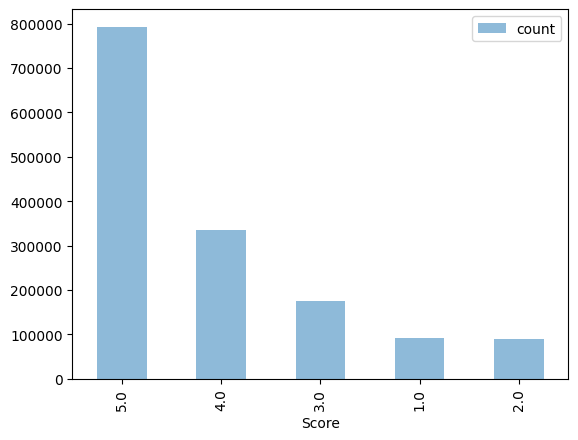


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [54]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print(trainingSet.columns.values)
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

# Make sure to comment this when submitting
# trainingSet = trainingSet[:10000]

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [55]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer


def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Calculate the length of the review text
    df['ReviewLength'] = df['Text'].fillna('').apply(len)

    # Calculate the length of the summary text
    df['SummaryLength'] = df['Summary'].fillna('').apply(len)
    
    # Sentiment analysis on review text
    df['TextPolarity'] = df['Text'].fillna('').apply(lambda x: TextBlob(x).sentiment.polarity)
    df['TextSubjectivity'] = df['Text'].fillna('').apply(lambda x: TextBlob(x).sentiment.subjectivity)

    # Word count in the review text
    df['WordCount'] = df['Text'].fillna('').apply(lambda x: len(x.split()))

    # Extract temporal features from Time column
    df['ReviewYear'] = pd.to_datetime(df['Time'], unit='s').dt.year
    df['ReviewMonth'] = pd.to_datetime(df['Time'], unit='s').dt.month
    df['ReviewWeek'] = pd.to_datetime(df['Time'], unit='s').dt.isocalendar().week
    df['ReviewDayOfWeek'] = pd.to_datetime(df['Time'], unit='s').dt.dayofweek  # 0=Monday, 6=Sunday
   
    # Interaction feature between review length and text polarity
    df['LengthPolarityInteraction'] = df['ReviewLength'] * df['TextPolarity']
    
    # 9. Log transformations for skewed features
    df['ReviewLength_log'] = np.log1p(df['ReviewLength'])
    df['WordCount_log'] = np.log1p(df['WordCount'])

    # 10. Aggregates by ProductId and UserId (averages as numeric values)
    df['UserAverageScore'] = df.groupby('UserId')['Score'].transform('mean')
    df['ProductAverageScore'] = df.groupby('ProductId')['Score'].transform('mean')
    
    # Fill missing values for new users or products with the overall average
    df['UserAverageScore'] = df['UserAverageScore'].fillna(df['Score'].mean())
    df['ProductAverageScore'] = df['ProductAverageScore'].fillna(df['Score'].mean())
    
    # 11. Sentiment analysis on the summary text
    df['SummaryPolarity'] = df['Summary'].fillna('').apply(lambda x: TextBlob(x).sentiment.polarity)
    df['SummarySubjectivity'] = df['Summary'].fillna('').apply(lambda x: TextBlob(x).sentiment.subjectivity)
    
    # 12. Interaction features: Helpfulness and Score, Review Length and Score
    df['HelpfulnessScoreInteraction'] = df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + 1e-5) * df['Score']
    df['LengthScoreInteraction'] = df['ReviewLength'] * df['Score']
    
    # 13. Word density in Text (average word length)
    df['AvgWordLength'] = df['Text'].fillna('').apply(lambda x: np.mean([len(word) for word in x.split()]) if x else 0)
    
    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train_blank.csv'):
    X_train = pd.read_csv("./data/X_train_crazy.csv")
if exists('./data/X_submission_blank.csv'):
    X_submission = pd.read_csv("./data/X_submission_crazy.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)
    print(train.columns.values)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission_real.csv", index=False)
    X_train.to_csv("./data/X_train_real.csv", index=False)

['Id' 'ProductId' 'UserId' 'HelpfulnessNumerator' 'HelpfulnessDenominator'
 'Time' 'Summary' 'Text' 'Score' 'Helpfulness' 'ReviewLength'
 'SummaryLength' 'TextPolarity' 'TextSubjectivity' 'WordCount'
 'ReviewYear' 'LengthPolarityInteraction' 'ReviewLength_log'
 'WordCount_log' 'UserAverageScore' 'ProductAverageScore'
 'SummaryPolarity' 'SummarySubjectivity' 'HelpfulnessScoreInteraction'
 'LengthScoreInteraction' 'AvgWordLength']


# Sample + Split into training and testing set

In [56]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [120]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE


features = [
    'HelpfulnessNumerator', 
    'HelpfulnessDenominator', 
    'Time', 
    'Helpfulness',                  # Ratio of Helpfulness
    'ReviewLength',                 # Length of review text
    'SummaryLength',                # Length of summary text
    'TextPolarity',                 # Sentiment polarity of the review text
    'TextSubjectivity',             # Sentiment subjectivity of the review text
    'WordCount',                    # Word count of the review text
    'ReviewYear',                   # Year the review was posted 
    'ReviewMonth',
    'ReviewWeek',
    'ReviewDayofWeek',
    # new from here
    'LengthPolarityInteraction',    # Interaction between review length and polarity
    'WordCount_log',                # Log-transformed word count
    'UserAverageScore',             # Average score per user
    'ProductAverageScore',           # Average score per product
    'SummaryPolarity',
    'SummarySubjectivity',
    'HelpfulnessScoreInteraction',
    'LengthScoreInteraction',
    'AvgWordLength',
]

# Adding TF-IDF columns to the features list
# tfidf_features = [f'tfidf_{i}' for i in range(100)]  # Assuming max_features=100 for TF-IDF
# features.extend(tfidf_features)

print(X_train.columns.values)

    
X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# # Standardize the features to ensure Lasso works effectively
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_select)
X_test_scaled = scaler.transform(X_test_select)

# Apply LassoCV to determine the best alpha (regularization strength) and fit the model
lasso = LassoCV(cv=5, random_state=42).fit(X_train_scaled, Y_train)
optimal_alpha = lasso.alpha_
print(f"Optimal alpha from LassoCV: {optimal_alpha}")


selected_features = [
    'HelpfulnessNumerator', 
    'HelpfulnessDenominator', 
    'Time', 
    'Helpfulness',                  # Ratio of Helpfulness
    'ReviewLength',                 # Length of review text
    'SummaryLength',                # Length of summary text
    'TextPolarity',                 # Sentiment polarity of the review text
    'TextSubjectivity',             # Sentiment subjectivity of the review text
    'WordCount',                    # Word count of the review text
    'ReviewYear',                   # Year the review was posted 
    # new from here
    'WordCount_log',                # Log-transformed word count
    'UserAverageScore',             # Average score per user
    'ProductAverageScore',           # Average score per product
    'SummaryPolarity',
    'SummarySubjectivity',
    'AvgWordLength',

    
]


# Update the feature sets to include only the selected features
X_train_select = X_train_select[selected_features]
X_test_select = X_test_select[selected_features]
X_submission_select = X_submission_select[selected_features]

print("Updated X_train_select, X_test_select, and X_submission_select with Lasso-selected features.")





['Id' 'ProductId' 'UserId' 'HelpfulnessNumerator' 'HelpfulnessDenominator'
 'Time' 'Summary' 'Text' 'Helpfulness' 'ReviewLength' 'SummaryLength'
 'TextPolarity' 'TextSubjectivity' 'WordCount' 'ReviewYear'
 'LengthPolarityInteraction' 'ReviewLength_log' 'WordCount_log'
 'UserAverageScore' 'ProductAverageScore' 'SummaryPolarity'
 'SummarySubjectivity' 'HelpfulnessScoreInteraction'
 'LengthScoreInteraction' 'AvgWordLength']
Updated X_train_select, X_test_select, and X_submission_select with Lasso-selected features.


# Model Creation

In [142]:
# Learn the model
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb



# Define the parameter grid for LightGBM
# param_grid = {
#     'num_leaves': [31, 50, 70],
#     'learning_rate': [0.1, 0.01],
#     'max_depth': [-1, 10, 20],
#     'feature_fraction': [0.8, 1.0],
#     'bagging_fraction': [0.8, 1.0],
#     'bagging_freq': [5, 10]
# }

# # Initialize the LightGBM classifier
# lgbm = LGBMClassifier(random_state=42)

# # Set up GridSearchCV with 3-fold cross-validation
# grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# # Fit the grid search on the training set
# grid_search.fit(X_train_select, Y_train)

# # Best model after tuning
# best_lgbm_model = grid_search.best_estimator_
# print("Best parameters found: ", grid_search.best_params_)

# # Evaluate the tuned model on the validation set
# Y_test_predictions = best_lgbm_model.predict(X_test_select)

# Step 1: Tune Hyperparameters for Base Models
# Example hyperparameter tuning for RandomForest

# Define a grid of hyperparameters to tune
xgb_classifier = xgb.XGBClassifier(
    objective='multi:softmax',  # For multi-class classification
    num_class=len([0,1,2,3,4]),  # Number of unique classes in y
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Train the model
xgb_classifier.fit(X_train_select, Y_train-1)

Y_test_predictions0 = xgb_classifier.predict(X_test_select+1)
print("Xgb accuracy: ", accuracy_score(Y_test, Y_test_predictions0))


lgbm_model = LGBMClassifier(
    n_estimators=888,
    learning_rate=0.016486206098036624,
    max_depth=10,
    num_leaves=36,
    subsample=0.5876457482520973,
    colsample_bytree=0.5948404239217249,
    min_child_samples=42,
    random_state=0,
    verbose=-1).fit(X_train_select, Y_train)


Y_test_predictions = lgbm_model.predict(X_test_select)
print("LGBM accuracy: ", accuracy_score(Y_test, Y_test_predictions))


# # Plot feature importance
# lgb.plot_importance(lgbm_model)  # Shows the top 10 features
# plt.title("Feature Importance")
# plt.show()

rf_model = RandomForestClassifier(n_estimators= 996, max_depth= 19, min_samples_split= 15, min_samples_leaf= 2, max_features= 'sqrt', bootstrap= True)
rf_model.fit(X_train_select, Y_train)
Y_test_predictions2 = rf_model.predict(X_test_select)
print("RandomForestClassifier accuracy: ", accuracy_score(Y_test, Y_test_predictions2))
    


131283     4.0
1202017    1.0
511808     0.0
955172     3.0
735507     4.0
          ... 
152315     4.0
963395     3.0
117952     4.0
1484405    4.0
305711     3.0
Name: Score, Length: 1114005, dtype: float64


c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:08:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Xgb accuracy:  0.22571740956976968
LGBM accuracy:  0.6479414869552104
RandomForestClassifier accuracy:  0.6397359803520262


# Model Evaluation

Accuracy on testing set =  0.6479414869552104


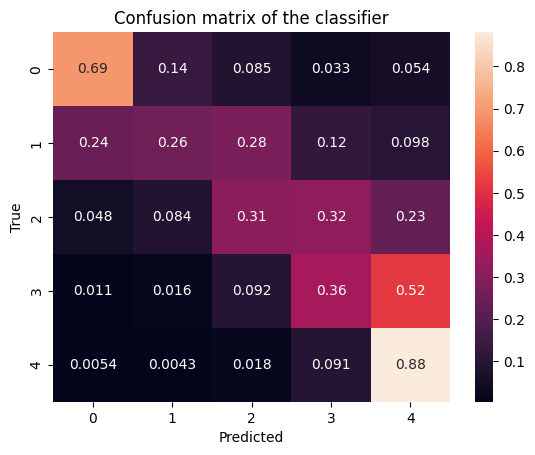

In [122]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# 5651

# Create submission file

In [123]:
# Create the submission file

X_submission['Score'] = lgbm_model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)